# 1. Setup

### Import dependecies

In [12]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt

In [13]:
# import Tensorflow functional API

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

### Set GPU growth

In [14]:
# Avoid out of memory error by setting GPU memory consumption growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

### Create folder structure 

In [15]:
POSITIVE_PATH = os.path.join('data', 'positive')
NEGATIVE_PATH = os.path.join('data', 'negative')
ANCHOR_PATH = os.path.join('data', 'anchor')

# creating directories

# os.makedirs(POSITIVE_PATH)
# os.makedirs(NEGATIVE_PATH)
# os.makedirs(ANCHOR_PATH)

# 2. Collect images

### Untar labelled faces in the wild dataset

In [16]:
# uncompress tar gz file
# !tar -xf lfw.tgz

^C


In [19]:
# move LFW images tothe following repository data/negative

for directory in os.listdir('lfw'):
    file_path = os.path.join('lfw', directory)
    for file in os.listdir(file_path):
        EXISING_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEGATIVE_PATH, file)
        os.replace(EXISING_PATH, NEW_PATH)

### Collect Positive and anchor images

In [20]:
# establishing a connection to webcam

cap = cv2.VideoCapture(0)

while cap.isOpened():
    
    ret, frame = cap.read()
    
    # show image back to screen
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

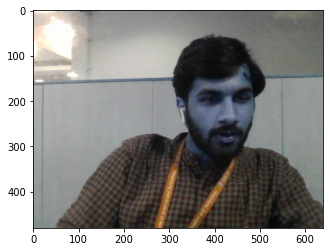

In [21]:
plt.imshow(frame)